# 07 — RNN, LSTM i GRU: sekwencje i pamięć


**Dlaczego to robimy?**  
Nie wszystkie dane są „obrazami”. Często mamy **sekwencje**:
- tekst (znaki/słowa),
- sygnały czasowe (sensor, audio),
- serie czasowe,
- zachowanie użytkownika (kliknięcia w czasie).

RNN to klasyczny mechanizm, który przetwarza sekwencję krok po kroku i ma **stan ukryty** (pamięć).

> W praktyce duże NLP dziś dominuje Transformer, ale RNN/LSTM/GRU dalej świetnie uczą intuicji o sekwencjach.


---

## Plan
1. Intuicja i równania RNN (unrolling)
2. BPTT + zanikający/eksplodujący gradient
3. LSTM i GRU (gating) — po co i jak
4. Eksperyment: „zapamiętaj pierwszy bit” (RNN vs LSTM vs GRU)
5. Mini‑zadania do modyfikacji


## 1) RNN — podstawowa idea

Dla sekwencji wejściowej $x_1, x_2, \dots, x_T$ RNN utrzymuje **stan ukryty** $h_t$.

Najprostsza wersja (vanilla RNN):

$
h_t = \tanh(W_x x_t + W_h h_{t-1} + b),
\qquad
\hat y_t = W_y h_t + c
$

**Unrolling (odwijanie w czasie)**  
Ten sam „klocek” (te same wagi) jest używany w każdym kroku czasu.

**Ważne:** wagi są współdzielone w czasie → mało parametrów, ale gradient musi „przejść” przez wiele kroków.

---

### Kształty tensorów (praktyczne)
W PyTorch najczęściej używamy:
- `batch_first=True`: wejście ma kształt **(batch, time, features)**,
- wyjście RNN ma:
  - `output`: (batch, time, hidden),
  - $h_n$: (num_layers, batch, hidden)

**Pytanie kontrolne:**  
Co weźmiesz jako reprezentację całej sekwencji, jeśli chcesz klasyfikować całą sekwencję (many‑to‑one)?


## 2) BPTT i problem z długą pamięcią (vanishing / exploding gradient)

RNN uczy się przez **Backpropagation Through Time (BPTT)**:  
gradient przechodzi przez kolejne kroki czasu.

W uproszczeniu gradient wygląda jak iloczyn wielu macierzy (pochodnych):
$
\frac{\partial \mathcal{L}}{\partial h_{t-k}} \approx
\left(\prod_{i=t-k+1}^{t} \frac{\partial h_i}{\partial h_{i-1}}\right)
\frac{\partial \mathcal{L}}{\partial h_{t}}
$

Jeśli normy tych pochodnych są:
- mniejsze niż 1 → gradient **zanika** (vanishing) → trudno uczyć długie zależności,
- większe niż 1 → gradient **eksploduje** (exploding) → niestabilne uczenie.

**Praktyczne triki:**
- `gradient clipping` (obcinanie normy gradientu),
- lepsze architektury: **LSTM / GRU**.

---

## 3) LSTM i GRU — bramki jako kontrola przepływu informacji

W zwykłym RNN cała informacja jest zapisana w jednym stanie ukrytym $h_t$,
który w każdym kroku jest **w całości nadpisywany** przez nową nieliniową transformację.
To powoduje problemy z długą pamięcią (zanik gradientu).

LSTM i GRU rozwiązują ten problem, wprowadzając **bramki (gates)** —
czyli mechanizmy, które **kontrolują ile informacji jest zachowane, a ile zmienione**.

---

### LSTM — rozdzielenie pamięci długiej i krótkiej

LSTM ma **dwa stany**:
- **$c_t$** — *cell state* → pamięć długoterminowa  
- **$h_t$** — *hidden state* → stan roboczy / wyjściowy

Kluczowa idea:  
$c_t$ może być aktualizowane **prawie liniowo**, bez ciągłego „przepychania”
informacji przez $tanh$. To umożliwia długą pamięć.

#### Bramki w LSTM

1) **Forget gate** $f_t$
Decyduje **ile starej pamięci zachować**:
- $f_t ≈ 1$ → pamięć zostaje
- $f_t ≈ 0$ → pamięć jest zapominana

2) **Input gate** $i_t$ + kandydat $~c_t$
Decydują **co nowego zapisać do pamięci**:
- $i_t$ wybiera *czy* pisać
- $~c_t$ mówi *co* pisać

3) **Output gate** $o_t$
Decyduje **ile z pamięci wypuścić do stanu wyjściowego $h_t$**  
(dzięki temu pamięć może istnieć, ale nie zawsze być widoczna na wyjściu)

Schematycznie:

$
c_t = f_t ⊙ c_{t-1} + i_t ⊙ ~c_t  \\
h_t = o_t ⊙ tanh(c_t)
$


**Intuicja:**  
LSTM ma osobny „notes” ($c_t$), który może być długo przechowywany,
oraz „to co mówimy teraz” ($h_t$), które jest filtrowane przez bramki.

---

### GRU — jedna pamięć, ale sterowana bramkami

GRU upraszcza LSTM:
- ma **jeden stan** $h_t$ (nie ma osobnego $c_t$)
- ma **dwie bramki**

#### Bramki w GRU

1) **Update gate** $z_t$
Decyduje **ile starego stanu zachować**:
- $z_t ≈ 0$ → pamięć jest zachowana (long-term)
- $z_t ≈ 1$ → stan jest nadpisywany (short-term)

2) **Reset gate** $r_t$ 
Decyduje **czy przeszłość ma wpływać na nowy kandydat stanu**

Schematycznie:

$
h_t = (1 - z_t) ⊙ h_{t-1} + z_t ⊙ ~h_t
$



**Intuicja:**  
GRU nie rozdziela pamięci na „długą” i „krótką”,
ale pozwala **płynnie mieszać starą i nową informację**.

---

### LSTM vs GRU — kluczowa różnica

| Cecha | LSTM | GRU |
|-----|-----|-----|
| Osobna pamięć długoterminowa | ✅ $c_t$ | ❌ |
| Liczba bramek | 3 | 2 |
| Kontrola pamięci | Bardziej precyzyjna | Prostsza |
| Złożoność | Większa | Mniejsza |
| Praktyka | Bardziej stabilny dla bardzo długich sekwencji | Często szybszy, podobna skuteczność |

---


**Bramki istnieją po to, żeby sieć mogła:**
- zdecydować *co zapamiętać*,
- *jak długo to pamiętać*,
- *kiedy tę informację wykorzystać*.

Dzięki temu LSTM i GRU potrafią uczyć się zależności długoterminowych,
z którymi zwykłe RNN sobie nie radzą.


### Połączenia w stacked RNN/LSTM/GRU: czas $t$ (poziomo) i warstwy $L$ (pionowo). Poniżej jest dokładniejszy opis sieci. Tutaj dodałem, bo mamy 2 ładne schematy.
#### Warstwy L to jest góra-dół, czas t: lewo-prawo (tutaj mamy rekurencję)

W modelu z $L$ warstwami rekurencyjnymi są **dwa kierunki przepływu informacji**:

1) **Poziomo w czasie** (rekurencja): w każdej warstwie stan przechodzi z $t-1$ do $t$  
2) **Pionowo między warstwami**: w tym samym kroku czasu $t$ wyjście niższej warstwy jest wejściem wyższej

Schemat (intuicyjnie):
- $x_t$ wchodzi „od dołu” do warstwy 1,
- stan/wyjście $h_t$ może iść „do góry” do kolejnej warstwy,
- oraz „w prawo” do następnego kroku czasu.

Równania (dla RNN/GRU — analogicznie dla LSTM, tylko stan jest rozszerzony o $c_t$):
$$
h^{(1)}_t = f^{(1)}(x_t,\; h^{(1)}_{t-1})
$$
$$
h^{(2)}_t = f^{(2)}(h^{(1)}_t,\; h^{(2)}_{t-1})
$$
$$
\vdots
$$
$$
h^{(L)}_t = f^{(L)}(h^{(L-1)}_t,\; h^{(L)}_{t-1})
$$

Gdzie:
- indeks górny $(\ell)$ oznacza warstwę $\ell \in \{1,\dots,L\}$,
- indeks dolny $t$ oznacza krok czasu $t \in \{0,\dots,T-1\}$,
- $f^{(\ell)}$ to „komórka” danej warstwy (RNN/LSTM/GRU).

W LSTM zamiast samego $h^{(\ell)}_t$ mamy także pamięć $c^{(\ell)}_t$, ale idea połączeń (czas + warstwy) pozostaje taka sama.


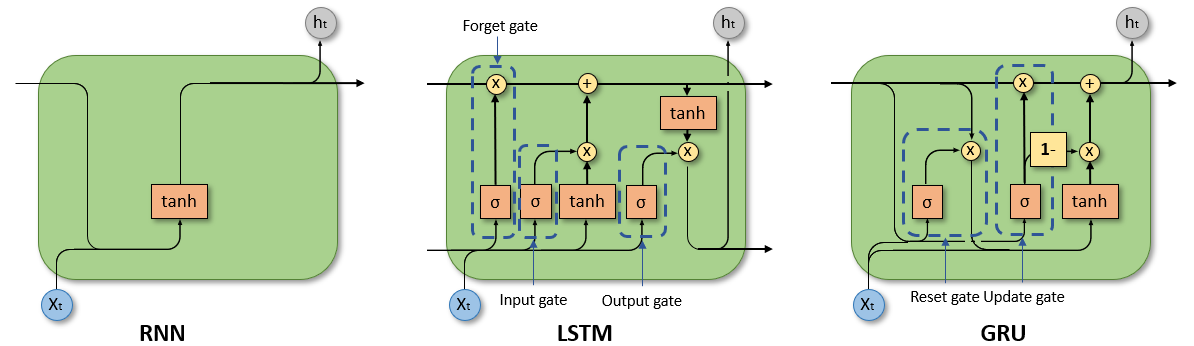

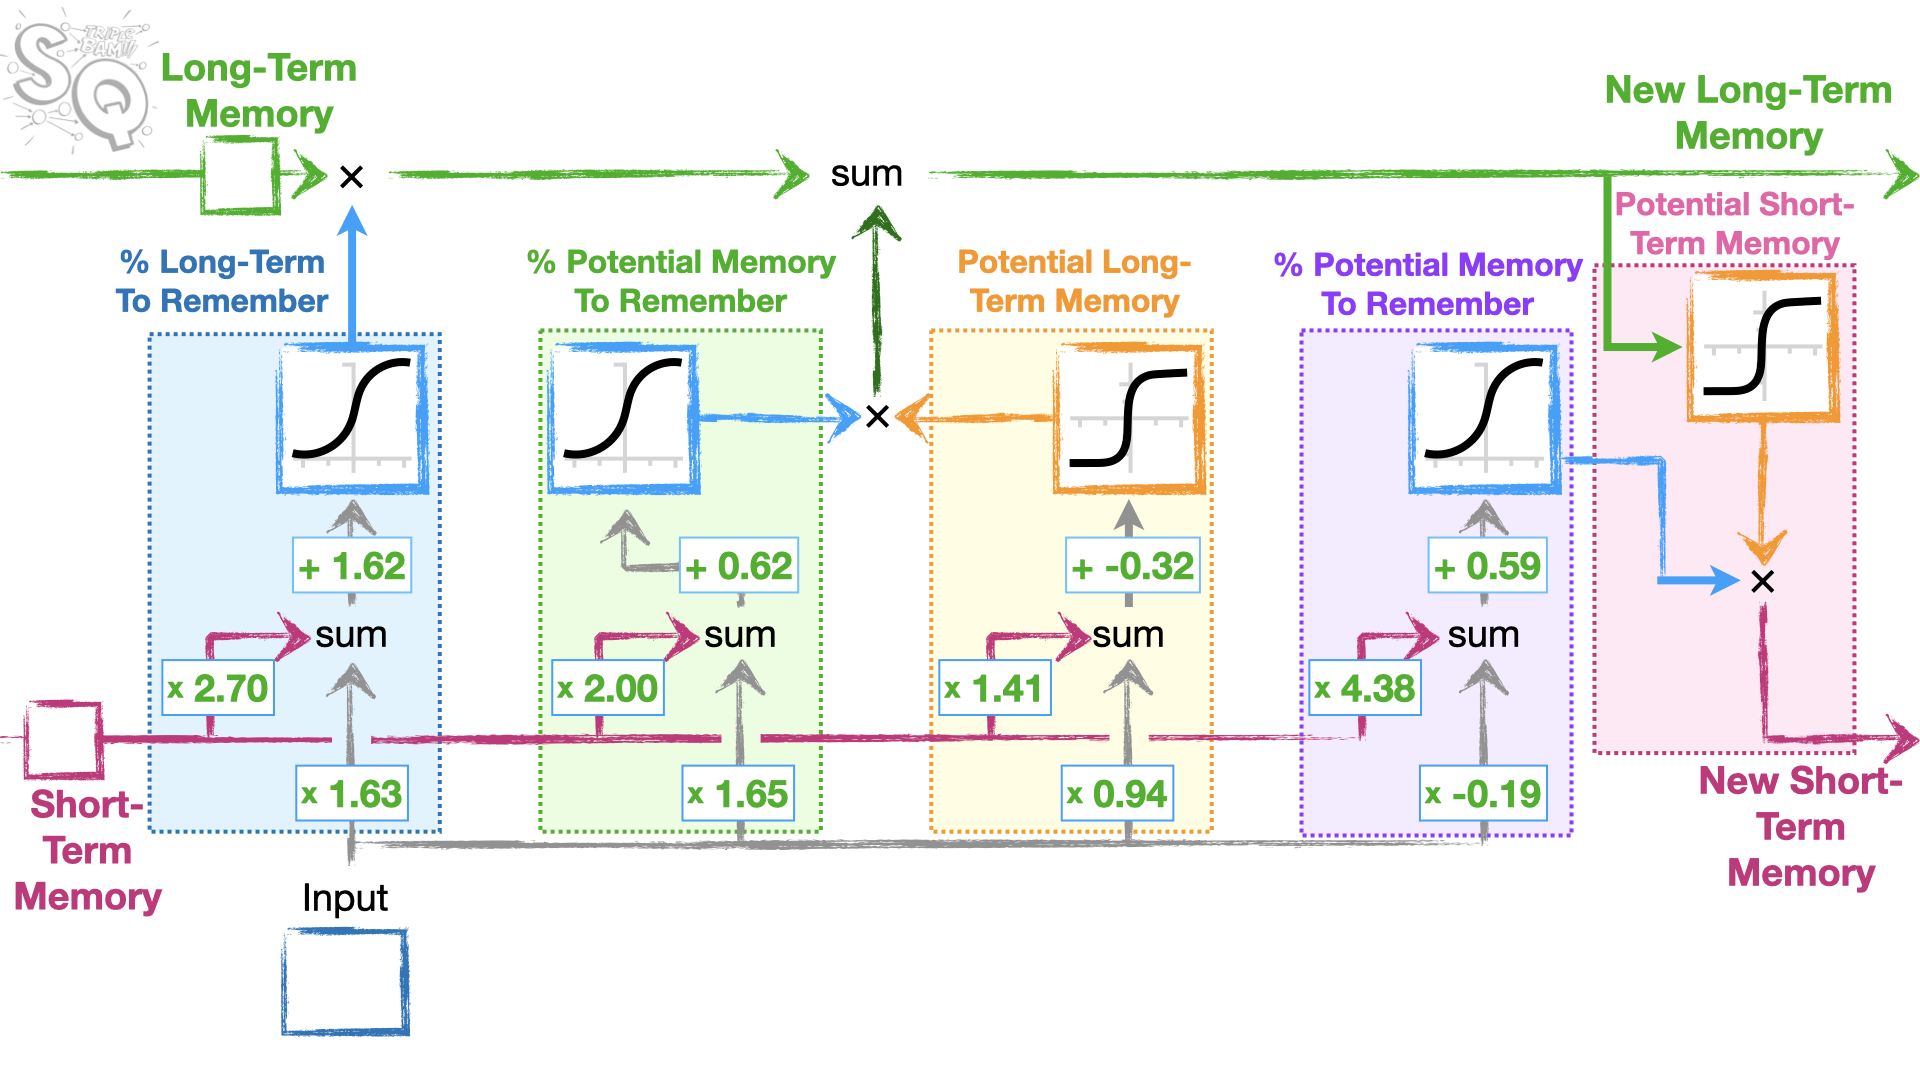

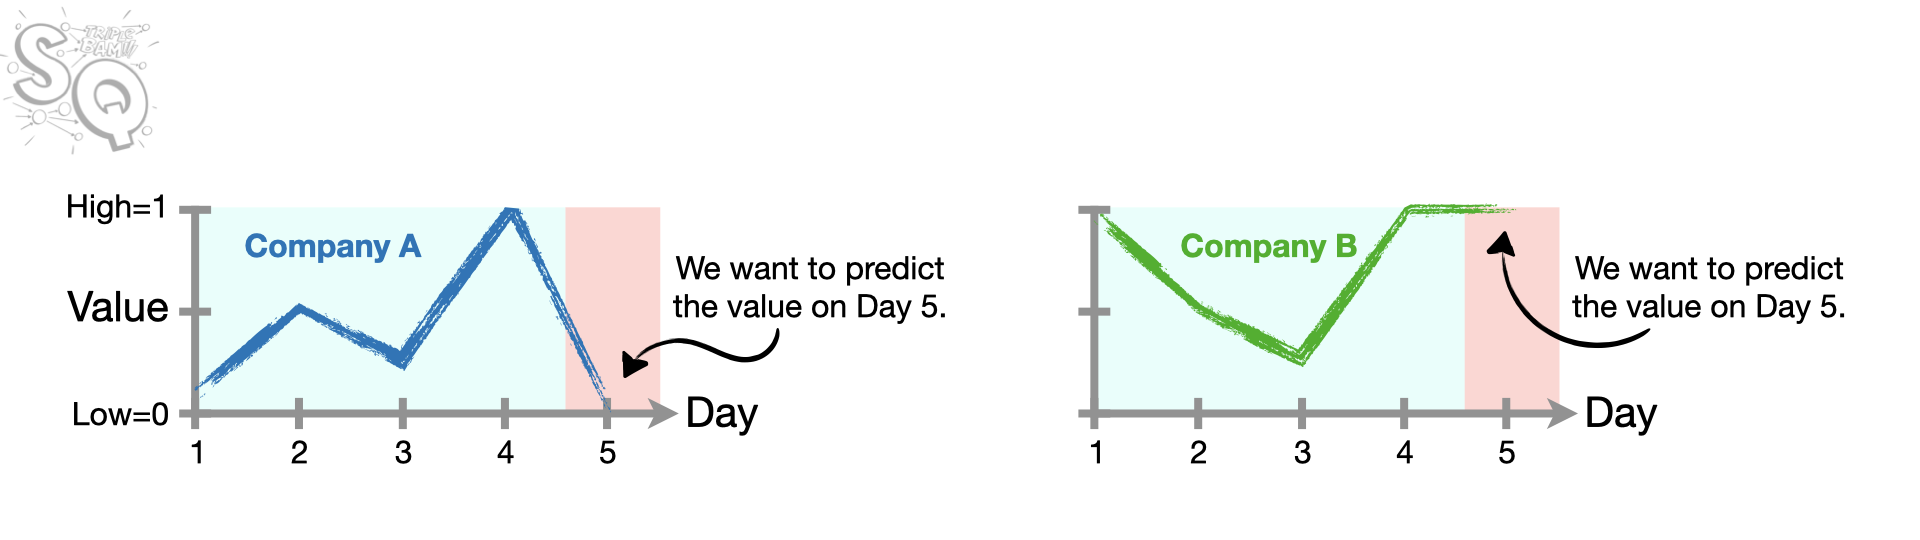

Żródło: https://github.com/StatQuest/signa/tree/main/chapter_08

In [90]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

def set_seed(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed((np.random.randint(0, 200)))
set_seed(0)

device: cpu


## 4) Eksperyment: „zapamiętaj pierwszy bit” (długa zależność)

### Opis zadania
Generujemy sekwencję bitów długości `T`:

- **pierwszy bit** `b ∈ {0,1}` jest informacją, którą trzeba zapamiętać,
- kolejne bity to losowy **szum** (nie niosą informacji o etykiecie),
- etykieta to `y = b` (czyli model ma na końcu powiedzieć, czy pierwszy bit był 0 czy 1).

Wejście kodujemy jako **one-hot**: każdy bit jest wektorem długości 2, więc `x` ma kształt `(B, T, 2)`.

To zadanie jest celowo sztuczne: wymusza przeniesienie informacji z początku sekwencji aż do końca, więc testuje **długoterminową zależność**.

### Oczekiwany efekt
- dla małych `T` nawet vanilla RNN może działać,
- dla większych `T` vanilla RNN często „łamie się” (test accuracy ~ 0.5),
- LSTM/GRU zwykle radzą sobie lepiej, bo mają bramki kontrolujące pamięć.

### Do zrobienia
- zwiększ `T` i zobacz, od jakiej długości RNN przestaje się uczyć,
- zmień `hidden_size` (pojemność pamięci),
- włącz/wyłącz `gradient clipping` (stabilność vs exploding gradients).


### Co tu jest czym? ($B$, $T$, sekwencja vs pamięć)

W tym przykładzie `generate_batch()` tworzy **dane wejściowe** (sekwencje w czasie).
**Pamięć** nie jest sekwencją — pamięć to **wewnętrzny stan modelu** (RNN/LSTM/GRU).

- $B$ (*batch size*) — liczba **niezależnych sekwencji** przetwarzanych równolegle.
- $T$ (*seq_len*) — długość **jednej sekwencji** (liczba kroków czasowych).
- $x \in \mathbb{R}^{B \times T \times 2}$ — wejście (one-hot bitów w czasie).
- $y \in \{0,1\}^B$ — etykieta, równa **pierwszemu bitowi** sekwencji.

Sekwencja to to, co model **widzi krok po kroku**:
$x[:,0] , x[:,1] , x[:,2] , ... , x[:,T-1]$

Pamięć to to, co model **niesie wewnątrz** między krokami:
- RNN / GRU: stan $h_t$
- LSTM: pamięć $c_t$ (długa) oraz stan $h_t$ (wyjściowy)

### Sens zadania „zapamiętaj pierwszy bit”
Pierwszy bit ($t=0$) niesie informację $b \in \{0,1\}$, a kolejne kroki to szum.
Model musi przewidzieć $y=b$ **na końcu sekwencji**, więc musi przenieść informację
z $t=0$ do $t=T-1$ w swojej pamięci.

Mini-schemat (dla jednego batcha):


In [91]:
import torch.nn.functional as F

def generate_batch(batch_size, seq_len, device=device):
    # losujemy etykietę y: pierwszy bit b ∈ {0,1} dla każdej sekwencji w batchu
    first = torch.randint(0, 2, (batch_size,), device=device)  # (B,)

    # losujemy całą sekwencję szumu (B,T) i nadpisujemy pierwszy krok etykietą
    seq = torch.randint(0, 2, (batch_size, seq_len), device=device)  # (B,T)
    seq[:, 0] = first  # pierwszy krok sekwencji niesie informację/etykietę

    # one-hot: 0 -> [1,0], 1 -> [0,1]; to jest wejście x do RNN/LSTM/GRU
    x = F.one_hot(seq, num_classes=2).float()   # (B,T,2)

    # etykieta klasy dla każdej sekwencji (model ma ją odtworzyć na końcu)
    y = first                                   # (B,)
    return x, y

# podgląd
x_demo, y_demo = generate_batch(batch_size=10, seq_len=8)
print("x_demo shape:", x_demo.shape, "y_demo:", y_demo)

print("Pierwszy krok (one-hot):\n", x_demo[:, 0, :].cpu().numpy())
print("Target y (pierwszy bit):\n", y_demo.cpu().numpy())


x_demo shape: torch.Size([10, 8, 2]) y_demo: tensor([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])
Pierwszy krok (one-hot):
 [[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
Target y (pierwszy bit):
 [0 1 1 0 1 1 1 1 1 1]


## 5) Modele: RNN vs LSTM vs GRU (ta sama główka)

Wszystkie modele poniżej mają ten sam schemat:

1. warstwa sekwencyjna (`RNN` / `LSTM` / `GRU`)
2. bierzemy **ostatni stan ukryty** jako reprezentację sekwencji (many‑to‑one)
3. linear → 2 klasy

Dzięki temu porównanie jest „uczciwe”: różni się tylko typ pamięci.


## Jak rozumieć SeqClassifier: RNN vs LSTM vs GRU (ten sam schemat)

Ta klasa buduje **klasyfikator sekwencji**: dostajemy sekwencję długości $T$ i zwracamy jedną odpowiedź (2 klasy: 0/1).  
Jest to schemat **many-to-one**: wiele kroków czasowych $\rightarrow$ jedna etykieta.

### 1) Wejście
Wejście $x$ ma kształt $(B, T, 2)$:
- $B$ — batch size (ile sekwencji naraz),
- $T$ — długość sekwencji,
- $2$ — one-hot bitu (0 $\rightarrow$ $(1,0)$, 1 $\rightarrow$ $(0,1)$).

### 2) Warstwa sekwencyjna: RNN / LSTM / GRU
W zależności od parametru cell\_type wybieramy jeden z trzech „silników pamięci”:
- RNN — prosta komórka z nieliniowością $\tanh$, często gubi długie zależności,
- LSTM — posiada bramki i dodatkową pamięć długoterminową $c_t$,
- GRU — uproszczona wersja z bramkami, bez osobnego $c_t$.

Wywołanie warstwy sekwencyjnej na $x$ zwraca:
- $output$ — stany ukryte dla **każdego** kroku czasu,
- $h_n$ — stan końcowy,
- w LSTM dodatkowo stan pamięci $c_n$.

Kształty tensorów:
- $output \in \mathbb{R}^{B \times T \times H}$, gdzie $H$ to hidden\_size,
- $h_n \in \mathbb{R}^{L \times B \times H}$, gdzie $L$ to liczba warstw (zwykle $L=1$),
- w LSTM: $c_n \in \mathbb{R}^{L \times B \times H}$.

#### Co oznacza $L$ w kształcie $(L,B,H)$?
$L$ to liczba warstw (stacked recurrent layers) sieci RNN/LSTM/GRU ułożonych jedna nad drugą, a nie długość sekwencji.  
Każda kolejna warstwa dostaje jako wejście sekwencję stanów z warstwy poprzedniej; $L$ nie oznacza „short-term memory”, tylko głębię modelu. 
Jak to działa intuicyjnie:

- warstwa 1 dostaje wejście $x_{1:T}$ i produkuje stany $h^{(1)}_{1:T}$

- warstwa 2 dostaje jako wejście sekwencję $h^{(1)}{1:T}$ i produkuje $h^{(2)}{1:T}$

- itd. aż do warstwy $L$ w $h^{(L)}$

### 3) Ostatni stan jako reprezentacja sekwencji (many-to-one)
Ponieważ zadanie ma **jedną etykietę na całą sekwencję**, bierzemy stan z końca:
- $h_{\text{last}} = h_n[-1] \in \mathbb{R}^{B \times H}$

Ten wektor ma być **podsumowaniem całej sekwencji**.  
W zadaniu „zapamiętaj pierwszy bit” oznacza to, że informacja z kroku $t=0$ musi zostać przeniesiona w pamięci aż do $t=T-1$.

### 4) Główka klasyfikacyjna (taka sama dla wszystkich modeli)
Główka liniowa mapuje:
- $(B, H) \rightarrow (B, 2)$

czyli:
- $logits \in \mathbb{R}^{B \times 2}$

Są to surowe wyniki dla dwóch klas (0 i 1).  
Funkcja straty typu CrossEntropy porównuje je z etykietą $y$.


#### Główka klasyfikacyjna (classification head) — schemat

Po warstwie sekwencyjnej (RNN/LSTM/GRU) mamy wektor reprezentacji sekwencji, np. $h_{\text{last}} \in \mathbb{R}^{B \times H}$.

Główka robi:
1) liniowe mapowanie do liczby klas $C$:
$z = W h_{\text{last}} + b$, gdzie $W \in \mathbb{R}^{C \times H}$, $b \in \mathbb{R}^{C}$, więc $z \in \mathbb{R}^{B \times C}$ (to są logits)
2) funkcja straty cross-entropy porównuje logits $z$ z etykietą $y$ i uczy $W,b$ oraz całą warstwę sekwencyjną.

Intuicja: główka to „czytnik” (readout), który z pamięci modelu wyciąga informację potrzebną do klasyfikacji.

#### Cross-entropy (krótko)
Cross-entropy to funkcja straty dla klasyfikacji: karze model za przypisanie małego prawdopodobieństwa poprawnej klasie.  
Dla jednej próbki strata ma postać $L=-\log(p_{\text{poprawna}})$, więc gdy model jest pewny i ma rację ($p\approx 1$), strata jest bliska $0$, a gdy się myli, rośnie.


### 5) Dlaczego to porównanie jest „uczciwe”?
Dla RNN, LSTM i GRU:
- wejście $x$ ma identyczny format,
- używana jest ta sama reprezentacja sekwencji $h_{\text{last}}$,
- główka klasyfikacyjna jest taka sama.

Jedyną różnicą jest **mechanizm pamięci** w warstwie sekwencyjnej.



### Słowniczek: $B$, $L$, $\tanh$ i bramki $\sigma$

**Batch $B$**  
$B$ to liczba sekwencji przetwarzanych równolegle w jednym kroku uczenia (mini-batch). Zwiększa to szybkość obliczeń i stabilizuje gradient (uśredniamy błąd po wielu przykładach), ale nie miesza sekwencji między sobą.

**Warstwy $L$ (stacked recurrent layers)**  
$L$ to liczba „pięter” RNN/LSTM/GRU ułożonych jedna nad drugą (głębia modelu), a nie długość sekwencji. Warstwa $1$ produkuje sekwencję stanów $h^{(1)}_{0:T-1}$, a warstwa $2$ dostaje je jako wejście i produkuje $h^{(2)}_{0:T-1}$, itd. aż do $h^{(L)}_{0:T-1}$.

**$\tanh$ (nieliniowość stanu)**  
W vanilla RNN aktualizacja stanu ma postać typu $h_t=\tanh(W_x x_t + W_h h_{t-1}+b)$, więc $\tanh$ „miesza” bieżące wejście z poprzednim stanem i ogranicza wartości do zakresu $(-1,1)$. W LSTM/GRU $\tanh$ też się pojawia (np. przy kandydacie pamięci), ale kluczową rolę w kontroli przepływu informacji pełnią bramki.

**Bramki i sigmoid $\sigma$**  
Bramki są zwykle liczone funkcją sigmoidalną $\sigma(u)=\frac{1}{1+e^{-u}}$, która daje wartości w $(0,1)$. Dzięki temu bramka działa jak „pokrętło” lub „zawór”:  
- wartość blisko $0$ oznacza „zablokuj/nie przepuszczaj”,  
- wartość blisko $1$ oznacza „przepuść/zachowaj”.

W LSTM bramki sterują m.in. tym, ile pamięci zachować ($f_t$), ile dopisać ($i_t$) i ile wypuścić na wyjście ($o_t$). W GRU podobną rolę pełnią bramki aktualizacji ($z_t$) i resetu ($r_t$).


In [92]:
class SeqClassifier(nn.Module):
    def __init__(self, cell_type="rnn", input_size=2, hidden_size=32, n_classes=2):
        super().__init__()
        self.cell_type = cell_type.lower()
        #definiujemy różne sieci sekwencyjne z pytorcha, wystarczy podać parametry danej sieci
        # a on już dostosuje odpowiednio sieć do zadanych parametrów, input,hidden,batch i/lub nonlinearity
        if self.cell_type == "rnn":
            self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True, nonlinearity="tanh")
        elif self.cell_type == "lstm":
            self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        elif self.cell_type == "gru":
            self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        else:
            raise ValueError("cell_type must be: rnn/lstm/gru")

        self.head = nn.Linear(hidden_size, n_classes)#zmapowanie ostatniej warstwy warstwy hidden na klasy outputu sieci

    def forward(self, x):
        # x: (B,T,2)
        out = self.rnn(x)
        if self.cell_type == "lstm":
            output, (h_n, c_n) = out # Rozdzielamy na dwa rodzaje pameici - lstm
        else:
            output, h_n = out # Rozdzielamy na dwa rodzaje pameici - rnn lub gru

        h_last = h_n[-1]         # (B, hidden) Ostatni element sekwencji
        logits = self.head(h_last)
        return logits

# sanity check kształtów
T = 64
x_tmp, y_tmp = generate_batch(5, T)
for ct in ["rnn", "lstm", "gru"]:
    m = SeqClassifier(ct, hidden_size=32).to(device)
    with torch.no_grad():
        logits = m(x_tmp)
    print(ct, "->", logits.shape)


rnn -> torch.Size([5, 2])
lstm -> torch.Size([5, 2])
gru -> torch.Size([5, 2])


## 6) Trening „w locie” (on-the-fly)

W tym zadaniu nie mamy stałego zbioru danych. Każdy batch jest generowany losowo przez funkcję $generate\_batch$, więc zamiast epok robimy po prostu $steps$ kroków optymalizacji.  
To jest podobne do RL w tym sensie, że za każdym krokiem dostajemy „nową próbkę ze środowiska” (tu: nowy batch sekwencji).

### Co dokładnie liczymy?

- Model zwraca $logits \in \mathbb{R}^{B \times C}$, gdzie w naszym zadaniu $C=2$ (klasa 0 vs 1).
- Strata $CrossEntropy$ porównuje logits z etykietą $y \in \{0,1\}^B$ i uczy model tak, aby przypisywał większe logits poprawnej klasie.

### Funkcje pomocnicze

1) Dokładność z logits:
- predykcja klasy to $ arg_{max}$ po wymiarze klas,
- accuracy to odsetek poprawnych odpowiedzi w batchu.

2) Ewaluacja na losowych batchach:
- ustawiamy model w tryb ewaluacji ($model.eval()$),
- wyłączamy gradienty ($@torch.no\_grad()$),
- liczymy średnią stratę i accuracy na $n_{batches}$ nowych, losowych batchach.
To daje stabilny pomiar „jak dobrze działa” bez overfitu na pojedynczym batchu.

### Pętla treningowa (co dzieje się w każdym kroku $step$)

Dla $step = 1,2,\dots$:

1) $model.train()$ — tryb treningu (np. dropout/batchnorm, jeśli byłyby użyte)

2) Generujemy batch: $(x_b, y_b) = generate\_batch(B, T)$  
   gdzie $x_b \in \mathbb{R}^{B \times T \times 2}$, $y_b \in \{0,1\}^B$

3) Zerujemy gradienty: $opt.zero\_grad()$

4) Forward: $logits = model(x_b)$

5) Strata: $loss = CE(logits, y_b)$

6) Backprop przez czas (BPTT): $loss.backward()$

7) Opcjonalnie gradient clipping:
   ograniczamy normę gradientu do $|g| \le max_{norm}$,
   co pomaga uniknąć exploding gradients (szczególnie w RNN).

8) Krok optymalizatora: $opt.step()$

Co 50 kroków (oraz na początku) raportujemy:
- train loss i train accuracy na aktualnym batchu,
- test loss i test accuracy jako średnią po wielu nowych losowych batchach.

### Dlaczego używamy gradient clipping?
W sieciach rekurencyjnych gradient może czasem „wybuchnąć” (exploding gradients), co destabilizuje uczenie.  
Clipping ogranicza wielkość kroku aktualizacji, stabilizując trening. (Nie leczy vanishing gradients, ale pomaga na exploding.)

In [93]:
loss_fn = nn.CrossEntropyLoss()
# strata dla klasyfikacji; w praktyce ~ -log(p_poprawnej)
# (PyTorch przyjmuje logits, softmax jest w środku)

def accuracy_from_logits(logits, y):
    pred = logits.argmax(dim=1)
    return (pred == y).float().mean().item()

@torch.no_grad()#Nie liczymy gradientów (to przyspiesza i oszczędza pamięć).
#W ewaluacji nic nie aktualizujemy, więc gradienty są zbędne.
def evaluate_random_batches(model, seq_len, n_batches=50, batch_size=256):#ewaluacja sieci w trakcie treningu
    model.eval()#tryb ewaluacji przeciwnie do model.train() zauważ, gdzie ten drugi tryb uruchamiamy za każdym razem.
    accs = []
    losses = []
    for _ in range(n_batches):
        xb, yb = generate_batch(batch_size, seq_len)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        accs.append(accuracy_from_logits(logits, yb))
        losses.append(loss.item())
    return float(np.mean(losses)), float(np.mean(accs))

def train_on_the_fly(cell_type, seq_len, hidden_size=32, steps=400, batch_size=128, lr=1e-3, clip_grad=1.0):
    model = SeqClassifier(cell_type=cell_type, hidden_size=hidden_size).to(device)
    opt = optim.Adam(model.parameters(), lr=lr)#Pan Adam :)

    hist = {"step": [], "train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    for step in range(1, steps+1):#kroki (iteracje) pętli treningowej - optymalizacji sieci
        model.train()
        xb, yb = generate_batch(batch_size, seq_len)

        opt.zero_grad() #Zerujemy gradienty - konieczne przed kolejnym brakprop
        logits = model(xb)  # model: (B,T,2) -> h_last -> head -> logits (B,2),
        # czyli mapujemy wartości z ostatniej warstwy kroku sekwencji h, czyli h_n na logity
        loss = loss_fn(logits, yb)
        loss.backward()#BPTT - BackPropagation Through Time

        if clip_grad is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad)#Gradient clipping 
            # - ochrona przed wybuchającym gradientem

        opt.step()#aktualizacja wag

        if step % 50 == 0 or step == 1:#Wyświetlanie stanu treningu
            tr_acc = accuracy_from_logits(logits, yb)
            te_loss, te_acc = evaluate_random_batches(model, seq_len, n_batches=30, batch_size=256)

            hist["step"].append(step)
            hist["train_loss"].append(loss.item())
            hist["train_acc"].append(tr_acc)
            hist["test_loss"].append(te_loss)
            hist["test_acc"].append(te_acc)

            print(f"[{cell_type}] step {step:4d}: train loss={loss.item():.4f}, acc={tr_acc:.3f} | test acc={te_acc:.3f}")

    return model, hist



## 7) Porównanie: RNN vs LSTM vs GRU na tym samym zadaniu

W tej sekcji porównujemy trzy architektury (RNN, LSTM, GRU) w **identycznych warunkach**:
- to samo zadanie „zapamiętaj pierwszy bit”,
- ten sam sposób czytania sekwencji: bierzemy reprezentację $h_{\text{last}}$ z końca,
- ta sama główka klasyfikacyjna i ta sama pętla treningowa.

### Parametry eksperymentu
Ustalamy:
- $T={SEQ_{LEN}}$ — długość sekwencji (ile kroków czasowych ma jedna sekwencja),
- $H={HIDDEN}$ — rozmiar stanu ukrytego (pojemność pamięci),
- ${STEPS}$ — liczba aktualizacji wag (ile kroków optymalizacji).

Im większe $T$, tym trudniej przenieść informację z początku ($t=0$) do końca ($t=T-1$),
więc vanilla RNN zwykle szybciej zaczyna mieć problem z długą zależnością.

### Co robi pętla poniżej?
Dla każdego typu komórki $\in\{\text{rnn},\text{lstm},\text{gru}\}$:
1) trenujemy model przez $\text{STEPS}$ kroków na losowo generowanych batchach,
2) zapisujemy:
   - model do słownika $models$,
   - historię treningu (loss/accuracy) do słownika $hists$.

### Co pokazuje wykres?
Rysujemy $test\ accuracy$ jako funkcję numeru kroku treningowego.
Ponieważ dane testowe są generowane losowo, „test” oznacza tu ocenę na świeżych batchach z tego samego rozkładu.

Interpretacja:
- jeśli $test\ acc \approx 0.5$, model w praktyce zgaduje (nie utrzymuje informacji o pierwszym bicie),
- jeśli $test\ acc$ rośnie do wartości bliskich $1.0$, model nauczył się „przenosić” informację przez całą sekwencję.

### Wskazówki praktyczne (gdy jest wolno)
Jeśli trening sprzęcie jest wolny, zmniejsz w pierwszej kolejności:
- ${STEPS}$ (mniej update’ów) - ilość kroków optymalizacji,
- $H=\text{HIDDEN}$ (mniejszy model) - wymiar pamięci krótkotrwałej/wymiar warstwy ukrytej,
- $T=SEQ_{LEN}$ (krótsze sekwencje) - długość łańcucha czasowego.


[rnn] step    1: train loss=0.7008, acc=0.508 | test acc=0.498
[rnn] step   50: train loss=0.6954, acc=0.492 | test acc=0.535
[rnn] step  100: train loss=0.6843, acc=0.570 | test acc=0.578
[rnn] step  150: train loss=0.3767, acc=0.898 | test acc=0.927
[rnn] step  200: train loss=0.0646, acc=1.000 | test acc=1.000
[rnn] step  250: train loss=0.0348, acc=1.000 | test acc=1.000
[rnn] step  300: train loss=0.0200, acc=1.000 | test acc=1.000
[rnn] step  350: train loss=0.0148, acc=1.000 | test acc=1.000
[rnn] step  400: train loss=0.0101, acc=1.000 | test acc=1.000
[lstm] step    1: train loss=0.6945, acc=0.453 | test acc=0.497
[lstm] step   50: train loss=0.6894, acc=0.633 | test acc=0.571
[lstm] step  100: train loss=0.6530, acc=0.680 | test acc=0.665
[lstm] step  150: train loss=0.3381, acc=0.883 | test acc=0.873
[lstm] step  200: train loss=0.0480, acc=1.000 | test acc=1.000
[lstm] step  250: train loss=0.0240, acc=1.000 | test acc=1.000
[lstm] step  300: train loss=0.0145, acc=1.000 | 

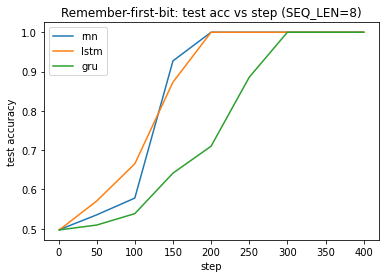

In [111]:
SEQ_LEN = 50
HIDDEN = 32
STEPS = 400

models = {}
hists = {}

for cell_type in ["rnn", "lstm", "gru"]:
    m, h = train_on_the_fly(cell_type, seq_len=SEQ_LEN, hidden_size=HIDDEN, steps=STEPS, batch_size=128, lr=1e-3, clip_grad=1.0)
    models[cell_type] = m
    hists[cell_type] = h

# wykres dokładności
plt.figure()
for cell_type, h in hists.items():
    plt.plot(h["step"], h["test_acc"], label=cell_type)
plt.xlabel("step")
plt.ylabel("test accuracy")
plt.title(f"Remember-first-bit: test acc vs step (SEQ_LEN={SEQ_LEN})")
plt.legend()
plt.show()


Zastanowić się czy takiego wyniku byśmy oczekiwali jak wyżej :)

## 7a) Co model „niesie” w stanie ukrytym w czasie?

W tym zadaniu etykieta $y$ zależy wyłącznie od **pierwszego bitu** sekwencji.  
To oznacza, że poprawnie działający model musi zrobić jedną rzecz:

> **zakodować informację o pierwszym bicie w stanie ukrytym i nie zgubić jej przez kolejne kroki czasu**.

### Co to znaczy „informacja jest w $h_t$”?

Dla każdej próbki w batchu i dla każdego kroku czasu model tworzy stan ukryty:
$
h_t^{(b)} \in \mathbb{R}^{H}
$
gdzie $H=\text{HIDDEN}$, a $t=1,\dots,T$ (tu $T=\text{SEQ\_LEN}$).

Jeżeli model rzeczywiście pamięta pierwszy bit, to zbiory stanów $\{h_t^{(b)}\}$ powinny się różnić w zależności od klasy:
- gdy $y=0$ (pierwszy bit 0),
- gdy $y=1$ (pierwszy bit 1).

W praktyce oznacza to, że w przestrzeni $\mathbb{R}^{H}$ będą dwie „chmury punktów”:
- jedna chmura dla $y=0$,
- druga dla $y=1$,
a ich środki (średnie) będą od siebie odsunięte.

### Prosty test: separacja średnich (krzywa $d(t)$)

Dla każdego czasu $t$ liczymy średni stan ukryty osobno dla każdej klasy:
$
\mu_0(t)=\mathbb{E}[h_t \mid y=0]\in\mathbb{R}^H,\qquad
\mu_1(t)=\mathbb{E}[h_t \mid y=1]\in\mathbb{R}^H.
$

Następnie mierzymy dystans między tymi średnimi:
$
d_t = \left\lVert \mu_1(t)-\mu_0(t)\right\rVert_2.
$

- Jeśli $d_t \approx 0$, to znaczy, że **dla tego czasu $t$** stany nie niosą praktycznie informacji o klasie (o pierwszym bicie).
- Jeśli $d_t$ jest duże, to znaczy, że **w stanie ukrytym da się odróżnić** przypadki $y=0$ i $y=1$.
- Najważniejsze są wartości dla późnych czasów ($t$ blisko $T$):  
  jeśli $d_t$ zostaje duże do końca, to informacja „dotrwała” do miejsca, w którym zwykle robimy predykcję.

### Jak czytać wykres typu z 7a?

Na osi:
- X: czas $t=1,\dots,T$,
- Y: $d_t$ (jedna liczba na każdy krok czasu).

Typowy sens kształtu krzywej:

1) **Wzrost $d_t$ w czasie**  
   Jeśli krzywa rośnie, to znaczy, że wraz z kolejnymi krokami model „krystalizuje” reprezentację klasy w $h_t$:
   mimo nowych bitów wejścia, stan ukryty coraz wyraźniej koduje informację o pierwszym bicie.

2) **Płaska krzywa blisko zera**  
   To oznacza, że model nie utrzymuje informacji o klasie w stanie ukrytym (w tym eksperymencie: „zapomina” pierwszy bit).

3) **Porównanie metod (rnn / gru / lstm)**  
   Dla długich sekwencji spodziewamy się zwykle:
   - `rnn`: słabsze utrzymanie informacji w czasie (zanik sygnału),
   - `gru/lstm`: lepsze utrzymanie (bramki pomagają zatrzymać istotną informację).

Uwaga: na wykresie krzywe rosną i są dość blisko siebie, co jest spójne z tym, że w danym ustawieniu
wszystkie trzy modele potrafią przenosić informację o 1. bicie.

---


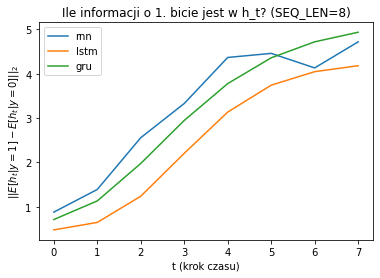

In [113]:
@torch.no_grad()
def hidden_separation_curve(model, seq_len, n_batches=20, batch_size=512):
    model.eval()
    curves = []
    for _ in range(n_batches):
        xb, yb = generate_batch(batch_size, seq_len)
        if model.cell_type == "lstm":
            output, (h_n, c_n) = model.rnn(xb)
        else:
            output, h_n = model.rnn(xb)
        # output: (B,T,H)
        m0 = output[yb == 0].mean(dim=0)  # (T,H)
        m1 = output[yb == 1].mean(dim=0)
        d = (m1 - m0).norm(dim=1)         # (T,)
        curves.append(d.detach().cpu().numpy())
    return np.mean(curves, axis=0)

# jeśli pominąłeś trening, zrób szybki trening "awaryjny"
if "models" not in globals() or not isinstance(models, dict) or len(models) == 0:
    print("Nie widzę wytrenowanych modeli, robię szybki trening (mniej kroków).")
    SEQ_LEN = 50
    models = {}
    for cell_type in ["rnn", "lstm", "gru"]:
        m, _ = train_on_the_fly(cell_type, seq_len=SEQ_LEN, hidden_size=32, steps=200, batch_size=128, lr=1e-3, clip_grad=1.0)
        models[cell_type] = m

plt.figure()
for cell_type, m in models.items():
    d = hidden_separation_curve(m, seq_len=SEQ_LEN, n_batches=20, batch_size=512)
    plt.plot(d, label=cell_type)

plt.xlabel("t (krok czasu)")
plt.ylabel(r"$||E[h_t|y=1] - E[h_t|y=0]||_2$")
plt.title(f"Ile informacji o 1. bicie jest w h_t? (SEQ_LEN={SEQ_LEN})")
plt.legend()
plt.show()


Ważne! Uwaga na oznaczenia indeksów. Tutaj sporo się miesza zauważyłem w notacji.


# Tutaj dodałem taką delikatną interpretację w stylu fizyki, ale może uda się dzisiaj jeszcze zrobić projekt z tym związany, dlatego zostawiam :) 
## Skąd wrażenie „przejścia fazowego” / niestabilności?

To wrażenie jest bardzo trafne: w treningu sieci często obserwuje się **nagłe przejście** z reżimu „losowego”
(`test_acc ~ 0.5`, `loss ~ ln 2`) do reżimu „rozwiązałem zadanie” (`test_acc → 1.0`).

To wygląda jak „przejście I rodzaju”, ale w praktyce jest to efekt **dynamiki optymalizacji**, a nie „statystyki” danych.

### Dlaczego to zwykle jest efekt treningu (optymalizacji), a nie „samej statystyki”?

1) **Dwa atrakcyjne reżimy rozwiązania**
- Reżim A: model nic sensownego nie koduje → predykcja ~losowa.
- Reżim B: model znalazł mechanizm pamięci (prosty „bit w stanie”) → bardzo dobra predykcja.

Między nimi bywa wąski „korytarz” w przestrzeni parametrów, więc przejście może wyglądać nagle.

2) **Losowość batchy i inicjalizacji**
Ponieważ dane są generowane losowo „on the fly”, a trening jest stochastyczny,
moment przejścia może się przesuwać i wyglądać niestabilnie.

3) **Gating w LSTM/GRU**
Bramki mogą na początku ustawić się w „bezpiecznym” trybie (mały przepływ informacji/gradientu),
a potem nagle wejść w reżim, gdzie pamięć zaczyna działać — co też daje efekt nagłego skoku.

### Czy da się to opisać „statystykami”?
Raczej nie w sensie teorii statystycznej danych, bo dane są tu proste (pierwszy bit + szum reszty).
Natomiast da się to opisać statystykami *wewnętrznymi treningu*, np.:
- `loss` w okolicy `ln 2` vs spadek poniżej,
- moment, gdy `d_T` (separacja na końcu sekwencji) przekracza pewien próg,
- stabilność krzywych $d_t$ między uruchomieniami.

To jest bardziej „statystyka procesu uczenia” niż „statystyka rozkładu danych”.

---

## Co dopisać jako krótką interpretację pod wykresem?

- Krzywe $d_t$ pokazują, jak długo informacja o pierwszym bicie pozostaje czytelna w stanie ukrytym.
- Jeśli $d_t$ jest duże aż do $t=T$, to znaczy, że model skutecznie przenosi informację przez całą sekwencję.
- „Nagłe skoki” w zachowaniu treningu (accuracy/loss) wynikają głównie z dynamiki optymalizacji (SGD/Adam + losowe batch’e),
a nie z „nagłej zmiany” danych.


###  Czy trening wygląda jak przejście fazowe, a `loss` jak parametr porządku? 

W praktyce: **tak, często wygląda**, zwłaszcza w prostych zadaniach typu „albo umiesz, albo nie umiesz”.
Widzimy wtedy dwie „fazy”:

- **faza losowa**:  
  `test_acc ≈ 0.5`, `loss ≈ ln(2)`  
  model nie koduje informacji o pierwszym bicie w stanie ukrytym (lub nie potrafi jej wykorzystać).

- **faza rozwiązania**:  
  `test_acc → 1.0`, `loss → 0`  
  model znalazł stabilną reprezentację/pamięć i potrafi na jej podstawie klasyfikować.

Przejście między nimi bywa **nagłe** (czasem w kilku-kilkunastu krokach), co wizualnie przypomina przejście fazowe.

#### Co może być „parametrem porządku”?

- `loss` jest wygodny, bo:
  - w fazie losowej jest blisko stałej wartości $ln(2)$,
  - w fazie rozwiązania spada w okolice zera.
  To zachowuje się jak *parametr*, który „zmienia stan układu”.

Ale **jeszcze lepszym parametrem porządku** w kontekście punktu 7a jest:

- **separacja pamięci na końcu sekwencji**, np. $d_T$:
  $
  d_T = \left\lVert \mathbb{E}[h_T \mid y=1] - \mathbb{E}[h_T \mid y=0] \right\rVert_2
  $
  Bo to mierzy bezpośrednio „czy informacja o pierwszym bicie dotrwała do końca”.

Wtedy interpretacja jest bardzo czysta:
- **faza losowa**: $d_T ≈ 0$
- **faza rozwiązania**: $d_T > 0$ (zwykle rośnie wraz z treningiem)

#### Czy to jest „prawdziwe” przejście fazowe?

To jest **analogia** do przejść fazowych, bo:
- nie mamy tu równowagi termodynamicznej,
- „sterowanie” nie jest temperaturą, tylko dynamiką optymalizacji (kroki SGD/Adam, losowość batchy),
- układ jest nieliniowy i stochastyczny.

Mimo to analogia działa, bo trening często ma dwa stabilne reżimy („atraktory”):
- rozwiązanie losowe (predykcja ~0.5),
- rozwiązanie poprawne (predykcja ~1).

A przełączenie między atraktorami może wyglądać jak „przeskok” (I rodzaj).

#### Skąd się bierze nagłość (intuicja w 2 zdaniach)

Model przez długi czas może poprawiać się „lokalnie”, ale nadal nie mieć mechanizmu pamięci.
Gdy parametry dojdą do punktu, w którym informacja zaczyna **przepływać przez czas** (utrzymuje się w $h_t$),
pojawia się dodatnie sprzężenie: lepsza pamięć → lepszy gradient → jeszcze lepsza pamięć, i krzywe robią skok.

#### Jak to pokazać w notebooku

Możemy traktować `loss` jako „parametr porządku” w sensie praktycznym,
a $d_T$ jako bardziej „mechanistyczny parametr porządku” (czy pamięć realnie żyje w stanie ukrytym).


## 7b) Vanishing gradient „na żywo”: jak czytać wykres $g_t = \mathbb{E}\| \partial \mathcal{L}/\partial h_t\|_2$?

W BPTT gradient przepływa przez czas.  
Da się to **zmierzyć** bez ręcznego liczenia pochodnych: robisz forward, liczysz loss, odpalasz `.backward()`, a potem patrzysz na gradient względem stanów ukrytych z każdego kroku.

Tu policzymy:
- oś X to czas $t=1,\dots,T$,
- oś Y to
  $
  g_t=\mathbb{E}_{\text{batch}}\Big[\big\|\frac{\partial \mathcal{L}}{\partial h_t}\big\|_2\Big]
  $
  pokazane w skali logarytmicznej.

**Intuicja:** $g_t$ mówi, jak silny sygnał uczenia (gradient) dociera do stanu ukrytego z kroku $t$,
gdy uczymy się na podstawie predykcji z końca sekwencji (`output[:, -1, :]`).

---


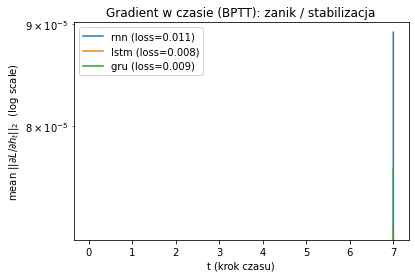

In [115]:
def grad_norm_curve(model, seq_len, batch_size=256):
    model.train(False)
    xb, yb = generate_batch(batch_size, seq_len)

    # dostajemy h_t w output: (B,T,H)
    if model.cell_type == "lstm":
        output, (h_n, c_n) = model.rnn(xb)
    else:
        output, h_n = model.rnn(xb)

    output.retain_grad()

    logits = model.head(output[:, -1, :])  # many-to-one: last hidden
    loss = loss_fn(logits, yb)

    try:
        model.zero_grad(set_to_none=True)
    except TypeError:
        model.zero_grad()
    loss.backward()

    g = output.grad  # (B,T,H)
    curve = g.norm(dim=2).mean(dim=0).detach().cpu().numpy()  # (T,)
    return curve, float(loss.item())

plt.figure()
for cell_type, m in models.items():
    curve, loss_val = grad_norm_curve(m, seq_len=SEQ_LEN, batch_size=256)
    plt.semilogy(curve, label=f"{cell_type} (loss={loss_val:.3f})")

plt.xlabel("t (krok czasu)")
plt.ylabel(r"mean $||\partial L / \partial h_t||_2$  (log scale)")
plt.title("Gradient w czasie (BPTT): zanik / stabilizacja")
plt.legend()
plt.show()



### Co widać na wykresie?

Na obrazku praktycznie wszystko jest „puste”, a widać jedynie cienkie pionowe kreski po prawej stronie.
To zwykle oznacza:

1) **Gradient jest ekstremalnie mały dla większości $t$**  
   W skali logarytmicznej wartości bliskie zera „znikają” wizualnie, więc linia może wyglądać jakby jej nie było.

2) **Sygnał gradientu jest skoncentrowany przy końcu sekwencji** (duże $t$)  
   Ponieważ loss zależy od `output[:, -1, :]`, to gradient naturalnie jest największy blisko końca,
   a dla wczesnych kroków (małe $t$) zanika po przejściu przez wiele mnożeń Jacobianów w BPTT.

3) **Modele są już bardzo dobrze wytrenowane** (`loss ~ 0.008–0.010`)  
   To jest ważne: gdy model prawie idealnie rozwiązuje zadanie,
   gradient ogólnie bywa mały (bo nie ma już „błędu do poprawiania”), więc krzywe mogą „siadać” wszędzie.

W skrócie: ta figura jest spójna z tym, że:
- uczymy many-to-one (loss z końca),
- gradient dla wczesnych czasów jest bardzo mały,
- a dodatkowo po zbieżności (mały loss) gradienty są jeszcze mniejsze.

---
 **vanishing gradient jest najbardziej widoczny, gdy model jeszcze nie umie**,
a tutaj `loss` jest już bliski zera.
---

### Co można powiedzieć o różnicach między RNN / GRU / LSTM (w tym teście)?

Ogólnie (dla dłuższych sekwencji i/lub w trakcie uczenia) oczekujemy:
- `rnn`: gradient dla małych $t$ szybciej zanika (krzywa opada bardziej stromo),
- `gru/lstm`: gradient utrzymuje się dłużej (mniej stromy spadek), bo bramki pomagają utrzymać informację i przepływ gradientu.

Ale: przy **bardzo małym loss** te różnice mogą być „spłaszczone” i trudne do odczytania z jednego wykresu.

---

### Jak to lepiej pokazać (jedna prosta modyfikacja eksperymentu)

Żeby zobaczyć zjawisko czytelniej, można wykonać wykresy dla modeli na różnych etapach treningu:
- np. po `steps = 20`, `50`, `100`, `200` (zamiast tylko po końcowym, prawie idealnym modelu).

Wtedy często widać „fazy”:
- na początku gradient jest silny przy końcu i prawie zerowy na początku,
- później (dla GRU/LSTM) sygnał może się utrzymywać głębiej w czasie.

---

### Jedno zdanie interpretacji

W tej konfiguracji (loss ≈ 0.01) gradienty są już bardzo małe; w skali logarytmicznej widać,
że sygnał uczenia jest praktycznie nieobecny dla większości kroków czasu i koncentruje się przy końcu sekwencji,
co jest zgodne z many-to-one i mechaniką BPTT (zanik gradientu wstecz w czasie).


## 7c) Bramki w LSTM/GRU: jak czytać wykresy i co widać w wynikach

Pamiętajmy, co robią bramki (w najkrótszej możliwej intuicji):

- **LSTM**
  - $i_t$ (input): ile nowej informacji zapisujemy do pamięci $c_t$,
  - $f_t$ (forget): ile starej pamięci $c_{t-1}$ zachowujemy,
  - $o_t$ (output): ile z pamięci pokazujemy na zewnątrz w stanie $h_t$.

- **GRU**
  - $z_t$ (update): miks „starego” i „nowego” stanu (pamięć vs aktualizacja),
  - $r_t$ (reset): czy przy liczeniu nowej propozycji stanu $n_t$ „kasujemy” wpływ starego $h_{t-1}$.

Wykresy, które rysujesz, to **średnie wartości bramek w czasie** (uśrednione po batchu i po jednostkach ukrytych).
To nie pokazuje całej złożoności (bo pojedyncze neurony mogą robić różne rzeczy), ale daje dobrą intuicję
„czy model jest w trybie utrzymania pamięci czy w trybie intensywnej aktualizacji”.

---
Jeśli linie wyglądają „nudno”, zwiększ `STEPS` albo `HIDDEN` i spróbuj ponownie — na tym zadaniu często widać, że LSTM ma:
- większe $i_t$ na początku (zapis),
- $f_t$ blisko 1 w środku (utrzymanie pamięci).


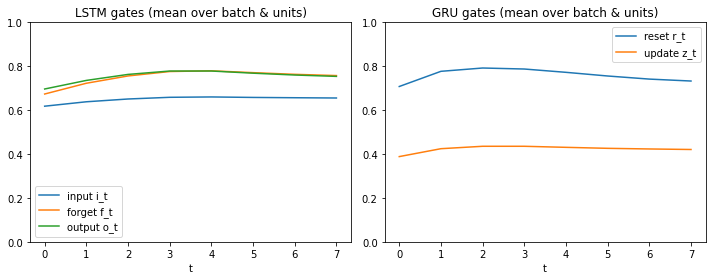

In [116]:
def lstm_gate_traces(lstm_module: nn.LSTM, x: torch.Tensor):
    # Zwraca (i,f,o) o kształcie (T,B,H) dla 1-warstwowego LSTM.
    W_ih = lstm_module.weight_ih_l0
    W_hh = lstm_module.weight_hh_l0
    b = lstm_module.bias_ih_l0 + lstm_module.bias_hh_l0
    H = lstm_module.hidden_size

    B, T, _ = x.shape
    h = torch.zeros(B, H, device=x.device)
    c = torch.zeros(B, H, device=x.device)

    i_list, f_list, o_list = [], [], []

    for t in range(T):
        xt = x[:, t, :]
        gates = xt @ W_ih.T + h @ W_hh.T + b
        i, f, g, o = gates.chunk(4, dim=1)   # PyTorch: i,f,g,o
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        g = torch.tanh(g)
        o = torch.sigmoid(o)

        c = f * c + i * g
        h = o * torch.tanh(c)

        i_list.append(i.detach())
        f_list.append(f.detach())
        o_list.append(o.detach())

    return torch.stack(i_list), torch.stack(f_list), torch.stack(o_list)

def gru_gate_traces(gru_module: nn.GRU, x: torch.Tensor):
    # Zwraca (r,z) o kształcie (T,B,H) dla 1-warstwowego GRU.
    W_ih = gru_module.weight_ih_l0
    W_hh = gru_module.weight_hh_l0
    b_ih = gru_module.bias_ih_l0
    b_hh = gru_module.bias_hh_l0
    H = gru_module.hidden_size

    B, T, _ = x.shape
    h = torch.zeros(B, H, device=x.device)

    r_list, z_list = [], []

    for t in range(T):
        xt = x[:, t, :]
        gi = xt @ W_ih.T + b_ih
        gh = h @ W_hh.T + b_hh

        r_i, z_i, n_i = gi.chunk(3, dim=1)   # PyTorch: r,z,n
        r_h, z_h, n_h = gh.chunk(3, dim=1)

        r = torch.sigmoid(r_i + r_h)
        z = torch.sigmoid(z_i + z_h)
        n = torch.tanh(n_i + r * n_h)

        h = (1 - z) * n + z * h

        r_list.append(r.detach())
        z_list.append(z.detach())

    return torch.stack(r_list), torch.stack(z_list)

# dane do wizualizacji bramek
xb_vis, yb_vis = generate_batch(batch_size=256, seq_len=SEQ_LEN)

plt.figure(figsize=(10, 4))

# LSTM
if "lstm" in models:
    lstm_mod = models["lstm"].rnn
    i, f, o = lstm_gate_traces(lstm_mod, xb_vis)

    i_m = i.mean(dim=(1, 2)).cpu().numpy()
    f_m = f.mean(dim=(1, 2)).cpu().numpy()
    o_m = o.mean(dim=(1, 2)).cpu().numpy()

    plt.subplot(1, 2, 1)
    plt.plot(i_m, label="input i_t")
    plt.plot(f_m, label="forget f_t")
    plt.plot(o_m, label="output o_t")
    plt.title("LSTM gates (mean over batch & units)")
    plt.xlabel("t")
    plt.ylim(0, 1)
    plt.legend()

# GRU
if "gru" in models:
    gru_mod = models["gru"].rnn
    r, z = gru_gate_traces(gru_mod, xb_vis)

    r_m = r.mean(dim=(1, 2)).cpu().numpy()
    z_m = z.mean(dim=(1, 2)).cpu().numpy()

    plt.subplot(1, 2, 2)
    plt.plot(r_m, label="reset r_t")
    plt.plot(z_m, label="update z_t")
    plt.title("GRU gates (mean over batch & units)")
    plt.xlabel("t")
    plt.ylim(0, 1)
    plt.legend()

plt.tight_layout()
plt.show()




### Co widać wykresie (LSTM – lewy panel)

Na lewym panelu widzimy, że:
- $i_t$, $f_t$, $o_t$ są dość wysokie (blisko górnego zakresu, powiedzmy ~0.7–0.8),
- $i_t$ i $f_t$ bardzo szybko rosną na początku i potem przechodzą w plateau,
- $o_t$ jest też wysokie, ale nieco niższe / bardziej płaskie niż pozostałe.

**Interpretacja:**
- W tym zadaniu sygnał (pierwszy bit) jest „łatwy” do przechowania, więc LSTM szybko przechodzi w reżim:
  - **zapisz na początku** (wysokie $i_t$ na starcie),
  - **potem utrzymuj** (wysokie $f_t$ przez środek sekwencji),
  - **i wciąż wypuszczaj** informację do $h_t$ (umiarkowanie wysokie $o_t$).

To pasuje do intuicji „LSTM jako komórka z pamięcią”, gdzie $c_t$ działa jak bufor długoterminowy.

Uwaga dydaktyczna:
- Ponieważ tu uśredniasz po całym batchu i wszystkich neuronach, krzywe wyglądają „gładko”.
  W rzeczywistości część neuronów może mieć bramki blisko 0, a część blisko 1 — średnia to wygładza.

---

### Co widać wykresie (GRU – prawy panel)

Na prawym panelu:
- $r_t$ (reset) jest dość wysokie (~0.7–0.8) i lekko maleje,
- $z_t$ (update) jest wyraźnie niższe (~0.3–0.4) i prawie płaskie.

**Interpretacja:**
- Niskie / umiarkowanie niskie $z_t$ oznacza, że GRU częściej „wpuszcza” nowe $n_t$ do stanu
  (bo $h_t = (1-z_t)n_t + z_t h_{t-1}$, więc mniejsze $z_t$ → większy udział nowego).
- Wysokie $r_t$ oznacza, że przy wyliczaniu $n_t$ model nie „resetuje” mocno przeszłości:
  przeszłość nadal pomaga w produkcji propozycji nowego stanu.
- To jest spójne z prostym zadaniem: GRU nie musi agresywnie kasować historii,
  a aktualizacje są dość równomierne w czasie.

---

## Co ciekawego dopisać: dlaczego bramki wyglądają „nudno”?
W tym zadaniu bramki często nie pokazują dramatycznych zmian,
bo strategia optimum jest prosta:

1) „Złap pierwszy bit na starcie”
2) „Przenieś go do końca”
3) „Zignoruj resztę”

Dla wielu neuronów to kończy się podobnym ustawieniem bramek przez cały czas.
Dlatego średnie po (batch, units) wyglądają jak spokojne plateau.

Jeśli chcesz, aby bramki miały bardziej „charakterystyczne kształty”, to zwykle pomaga:
- większe `SEQ_LEN`,
- trudniejsze zadanie (np. „xor z kilku pozycji”, albo „bit z losowej pozycji”),
- patrzenie nie na średnią, tylko np. na kilka wybranych neuronów (top-k), albo rozkład (histogram).

---

## Co dopisać analogicznie do 7b (figura z gradientem)

Figura z 7b wygląda „pusto”, bo:
- `loss` jest już bardzo mały (`~0.01`), więc gradienty są małe,
- a w many-to-one gradient naturalnie jest najsilniejszy blisko końca sekwencji,
  dla wczesnych $t$ zanika (BPTT + mnożenie Jacobianów).

**Ciekawe zdanie do notebooka:**
> Wykres $g_t$ jest najbardziej informacyjny, gdy model jest w trakcie uczenia (większy loss).
> Po zbieżności gradienty są małe niemal wszędzie, więc różnice między RNN/GRU/LSTM mogą być słabo widoczne.

---

## Dwie krótkie obserwacje:

- **7b:** $g_t$ pokazuje, jak daleko w przeszłość realnie dociera sygnał uczenia z końcowej decyzji.
- **7c:** bramki pokazują, czy komórka pracuje w trybie „zapis/utrzymanie/odczyt” (LSTM) lub „miks stare/nowe” (GRU).

---

### Mały disclaimer (ważny, ale krótki)

Ponieważ uśredniamy po batchu i neuronach, wykresy bramek są „makroskopowe”.
Mogą ukrywać fakt, że w środku część neuronów jest w reżimie 0/1 (dyskretne „przełączniki pamięci”),
a część działa inaczej — średnia to wygładza.


## 8) Jak trudność rośnie z długością sekwencji?

Ten blok robi mini‑benchmark: dla kilku wartości `SEQ_LEN` trenuje model przez tę samą liczbę kroków i mierzy accuracy.

**Uwaga:** to może chwilę potrwać (bo to pętla w pętli).  
Na zajęciach możesz uruchomić tylko dla 2–3 długości.

**Zadanie** Wykonaj tę analizę dla różnych długości oraz wszystkich poznanych metod


In [99]:
DO_SCAN = False  # ustaw True jeśli chcesz uruchomić (może trwać)

if DO_SCAN:
    seq_lens = [10, 30, 50, 80]# A może inaczej?! :)
    results = {"rnn": [], "lstm": []}

    for L in seq_lens:
        print("\nSEQ_LEN =", L)
        for cell_type in ["rnn", "lstm"]:
            _, h = train_on_the_fly(cell_type, seq_len=L, hidden_size=32, steps=250, batch_size=128, lr=1e-3, clip_grad=1.0)
            results[cell_type].append(h["test_acc"][-1])

    # wykres
    plt.figure()
    for cell_type, accs in results.items():
        plt.plot(seq_lens, accs, marker='o', label=cell_type)
    plt.xlabel("SEQ_LEN")
    plt.ylabel("final test accuracy")
    plt.title("Wpływ długości sekwencji")
    plt.legend()
    plt.show()


# Podsumowanie

**Najważniejsze wnioski:**
1. RNN przetwarza sekwencję krok po kroku i utrzymuje stan $h_t$.
2. BPTT to backprop „przez czas” → przy długich sekwencjach pojawia się vanishing/exploding gradient.
3. LSTM i GRU dodają bramki (gating), które pomagają kontrolować przepływ informacji i poprawiają „pamięć”.
4. W praktyce warto umieć:
   - dobrać kształty tensorów,
   - wybrać reprezentację sekwencji (np. ostatni hidden state),
   - używać gradient clipping.

---

# Mini‑zadania
- Zmień zadanie na „zapamiętaj **ostatni** bit” — powinno być łatwe nawet dla RNN.
- Dodaj trzecią klasę i spraw, aby target zależał od dwóch pierwszych kroków.
- Zmień `SEQ_LEN` i narysuj wykres accuracy w funkcji długości.
- (Zaawansowane) Zrób „copy task”: w środku sekwencji pojawia się krótki wzorzec, a na końcu model ma go odtworzyć.


## 9) Bonus: attention pooling (many‑to‑one) — krótsza ścieżka dla gradientu

Wcześniej robiłeś many‑to‑one tak: bierzesz **ostatni** stan ukryty i klasyfikujesz.

To ma jeden duży minus: jeśli informacja siedzi na początku sekwencji, gradient musi wrócić przez cały czas.

Teraz zrób alternatywę: policz **ważoną sumę** wszystkich stanów $h_1,\dots,h_T$:

$
\alpha_t = \mathrm{softmax}(s_t),\quad
c = \sum_t \alpha_t h_t
$

i dopiero z $c$ zrób klasyfikację.  
To jest mini‑krok w stronę attention/self‑attention.



## 9) Bonus: attention pooling (many-to-one) — co dokładnie się dzieje i jak to działa?

W klasycznym many-to-one robiliśmy:
- bierzemy tylko ostatni stan `output[:, -1, :]` i z niego klasyfikujemy.

To oznacza, że jeśli informacja jest na początku sekwencji, to:
- model musi ją **przenieść** przez cały czas do końca,
- a gradient z loss wraca „ścieżką” długości ~`SEQ_LEN`.

### 9.1) Idea attention pooling w jednym zdaniu

Zamiast brać tylko ostatni stan, robimy **nauczalną (learnable) ważoną średnią** wszystkich stanów:
$
c = \sum_{t=1}^{T} \alpha_t h_t,
\quad \text{gdzie} \quad
\alpha_t \ge 0,\ \sum_t \alpha_t=1.
$

Potem klasyfikujemy z `c`.

---

## 9.2) Krok po kroku: co robi `AttentionPooling`

Masz `outputs` o kształcie `(B,T,H)`:
- $B$ — batch,
- $T$ — czas (`SEQ_LEN`),
- $H$ — wymiar stanu (`hidden_size`).

Dla każdego kroku czasu $t$ liczymy **score** (logit uwagi) $s_t$:

1) Projekcja do przestrzeni attention:
$
u_t = \tanh(W h_t)\in \mathbb{R}^{A}
$
gdzie `A = attn_size`, a `W` to `nn.Linear(hidden_size, attn_size)`.

2) Skalarowy score:
$
s_t = v^\top u_t \in \mathbb{R}
$
gdzie `v` to `nn.Linear(attn_size, 1, bias=False)`.

W kodzie:
- `scores = v(tanh(W(outputs)))` daje `(B,T,1)` i po `squeeze(-1)` mamy `(B,T)`.

3) Softmax po czasie:
$
\alpha_t = \mathrm{softmax}(s)_t
= \frac{e^{s_t}}{\sum_{\tau=1}^{T} e^{s_\tau}}
$
czyli `alpha` ma kształt `(B,T)` i sumuje się do 1 wzdłuż czasu.

4) Kontekst jako ważona suma stanów:
$
c = \sum_{t=1}^{T} \alpha_t h_t \in \mathbb{R}^{H}.
$
W kodzie:
- `context = (alpha.unsqueeze(-1) * outputs).sum(dim=1)` daje `(B,H)`.

Na końcu:
- `logits = head(context)`.

---

## 9.3) Dlaczego to skraca ścieżkę gradientu?

W baseline:
- `logits` zależą tylko od $h_T$,
- więc gradient musi „przepchnąć” informację z początku aż do końca (przez rekurencję).

W attention pooling:
- `logits` zależą od **wszystkich** $h_t$ poprzez sumę:
  $
  c = \sum_t \alpha_t h_t.
  $
To daje dwie ważne konsekwencje:

1) Gradient ma bezpośrednie połączenie do każdego $h_t$:
$
\frac{\partial \mathcal{L}}{\partial h_t}
\ \text{ma składnik wynikający wprost z}\ c,
$
bo $h_t$ wchodzi liniowo do sumy.

2) Model może „nauczyć się patrzeć” na istotne kroki:
- jeśli pierwszy bit jest kluczowy, to opłaca się zwiększyć $\alpha_1$ (lub okolice początku),
- wtedy informacja z początku trafia do `context` bez potrzeby przechodzenia przez całe BPTT.

To jest dokładnie sens zdania: **krótsza ścieżka dla gradientu**.

---

## 9.4) Co oznacza wykres `alpha_mean(t)`?

`alpha` to rozkład po czasie dla każdej próbki.
Na wykresie rysujesz:
$
\bar \alpha_t = \mathbb{E}_{\text{batch}}[\alpha_t].
$

Interpretacja:
- jeśli $\bar\alpha_t$ ma wyraźny pik blisko $t=1$, to model średnio „patrzy” na początek,
- jeśli jest płaskie, to pooling jest prawie zwykłą średnią,
- jeśli jest pik na końcu, to model i tak głównie korzysta z późnych stanów (jak baseline).

Uwaga: średnia po batchu może spłaszczać obraz (dla jednych próbek uwaga może być na początku, dla innych gdzie indziej).

---

## 9.5) Jak to się ma do „prawdziwego” self-attention?

To jeszcze nie jest pełny self-attention (Transformer), bo:
- tu score $s_t$ zależy tylko od $h_t$ (lokalnie),
- nie ma zapytań/kluczy/wartości między parami kroków czasu.

Ale to jest bardzo sensowny „mini-krok”:
- uczymy się, *które kroki czasu są ważne* dla decyzji many-to-one.

---

## 9.6) Co można dopisać jako mikro-wniosek do eksperymentu?

- Jeśli `attn_rnn` uczy się szybciej lub osiąga wyższą `test_acc` dla większego `SEQ_LEN`,
  to znaczy, że attention pooling pomaga RNN omijać problem „muszę przepchnąć pamięć do końca”.
- W takim przypadku wykres `alpha_mean(t)` często pokazuje większy ciężar na początku sekwencji
  (bo tam siedzi informacja o klasie).


Baseline (ostatni hidden) — RNN
step    1 | loss=0.7381 | test acc=0.503
step  100 | loss=0.6939 | test acc=0.495
step  200 | loss=0.6921 | test acc=0.496
step  300 | loss=0.6933 | test acc=0.499

Attention pooling — RNN
step    1 | loss=0.7049 | test acc=0.504
step  100 | loss=0.6835 | test acc=0.723
step  200 | loss=0.0218 | test acc=1.000
step  300 | loss=0.0056 | test acc=1.000

Porównanie test acc:
baseline_rnn: 0.50234375
attn_rnn:     1.0


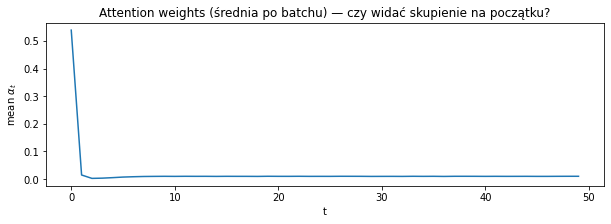

In [117]:
import math
import torch.nn.functional as F

class AttentionPooling(nn.Module):
    def __init__(self, hidden_size, attn_size=32):
        super().__init__()
        self.W = nn.Linear(hidden_size, attn_size)
        self.v = nn.Linear(attn_size, 1, bias=False)

    def forward(self, outputs):
        # outputs: (B,T,H)
        scores = self.v(torch.tanh(self.W(outputs))).squeeze(-1)  # (B,T)
        alpha = torch.softmax(scores, dim=1)                      # (B,T)
        context = (alpha.unsqueeze(-1) * outputs).sum(dim=1)      # (B,H)
        return context, alpha

class SeqClassifierAttn(nn.Module):
    def __init__(self, cell_type="rnn", input_size=2, hidden_size=32, n_classes=2):
        super().__init__()
        self.cell_type = cell_type.lower()

        if self.cell_type == "rnn":
            self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        elif self.cell_type == "lstm":
            self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        elif self.cell_type == "gru":
            self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        else:
            raise ValueError("cell_type must be: rnn/lstm/gru")

        self.pool = AttentionPooling(hidden_size, attn_size=32)
        self.head = nn.Linear(hidden_size, n_classes)

    def forward(self, x, return_attn=False):
        out = self.rnn(x)
        if self.cell_type == "lstm":
            output, (h_n, c_n) = out
        else:
            output, h_n = out

        context, alpha = self.pool(output)
        logits = self.head(context)

        if return_attn:
            return logits, alpha
        return logits

@torch.no_grad()
def eval_acc(model, seq_len, n_batches=30, batch_size=256):
    model.eval()
    accs = []
    for _ in range(n_batches):
        xb, yb = generate_batch(batch_size, seq_len)
        logits = model(xb)
        accs.append(accuracy_from_logits(logits, yb))
    return float(np.mean(accs))

def train_simple(model, seq_len, steps=400, lr=1e-3, batch_size=128, clip_grad=1.0):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)

    for step in range(1, steps+1):
        xb, yb = generate_batch(batch_size, seq_len)
        opt.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        if clip_grad is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad)
        opt.step()

        if step % 100 == 0 or step == 1:
            print(f"step {step:4d} | loss={loss.item():.4f} | test acc={eval_acc(model, seq_len):.3f}")

    return model

SEQ_LEN_ATT = 50

print("Baseline (ostatni hidden) — RNN")
baseline_rnn = SeqClassifier(cell_type="rnn", hidden_size=32).to(device)
baseline_rnn = train_simple(baseline_rnn, seq_len=SEQ_LEN_ATT, steps=300, lr=1e-3)

print("\nAttention pooling — RNN")
attn_rnn = SeqClassifierAttn(cell_type="rnn", hidden_size=32).to(device)
attn_rnn = train_simple(attn_rnn, seq_len=SEQ_LEN_ATT, steps=300, lr=1e-3)

print("\nPorównanie test acc:")
print("baseline_rnn:", eval_acc(baseline_rnn, SEQ_LEN_ATT))
print("attn_rnn:    ", eval_acc(attn_rnn, SEQ_LEN_ATT))

# Zobacz, gdzie attention „patrzy” (średnia w batchu)
xb_vis, yb_vis = generate_batch(batch_size=256, seq_len=SEQ_LEN_ATT)
logits, alpha = attn_rnn(xb_vis, return_attn=True)     # alpha: (B,T)

alpha_mean = alpha.mean(dim=0).detach().cpu().numpy()  # (T,)

plt.figure(figsize=(10, 3))
plt.plot(alpha_mean)
plt.title("Attention weights (średnia po batchu) — czy widać skupienie na początku?")
plt.xlabel("t")
plt.ylabel("mean $\\alpha_t$")
plt.show()


Baseline (ostatni hidden) — RNN
step    1 | loss=0.7001 | test acc=0.497
step  100 | loss=0.6935 | test acc=0.498
step  200 | loss=0.6918 | test acc=0.502
step  300 | loss=0.6924 | test acc=0.502

Attention pooling — RNN
step    1 | loss=0.7041 | test acc=0.496
step  100 | loss=0.6410 | test acc=0.735
step  200 | loss=0.0026 | test acc=1.000
step  300 | loss=0.0009 | test acc=1.000

Porównanie test acc:
baseline_rnn: 0.512890625
attn_rnn:     1.0


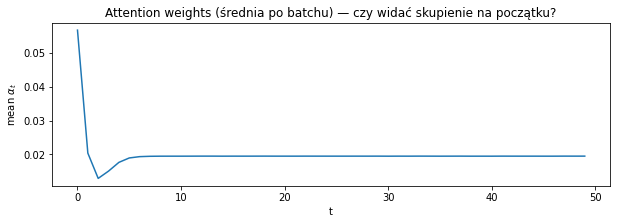

In [118]:

SEQ_LEN_ATT = 50

print("Baseline (ostatni hidden) — RNN")
baseline_rnn = SeqClassifier(cell_type="lstm", hidden_size=32).to(device)
baseline_rnn = train_simple(baseline_rnn, seq_len=SEQ_LEN_ATT, steps=300, lr=1e-3)

print("\nAttention pooling — RNN")
attn_rnn = SeqClassifierAttn(cell_type="lstm", hidden_size=32).to(device)
attn_rnn = train_simple(attn_rnn, seq_len=SEQ_LEN_ATT, steps=300, lr=1e-3)

print("\nPorównanie test acc:")
print("baseline_rnn:", eval_acc(baseline_rnn, SEQ_LEN_ATT))
print("attn_rnn:    ", eval_acc(attn_rnn, SEQ_LEN_ATT))

# Zobacz, gdzie attention „patrzy” (średnia w batchu)
xb_vis, yb_vis = generate_batch(batch_size=256, seq_len=SEQ_LEN_ATT)
logits, alpha = attn_rnn(xb_vis, return_attn=True)     # alpha: (B,T)

alpha_mean = alpha.mean(dim=0).detach().cpu().numpy()  # (T,)

plt.figure(figsize=(10, 3))
plt.plot(alpha_mean)
plt.title("Attention weights (średnia po batchu) — czy widać skupienie na początku?")
plt.xlabel("t")
plt.ylabel("mean $\\alpha_t$")
plt.show()

## 10) Bonus: self‑attention (mini‑transformer bez „pełnego” transformera)

Attention pooling robi: „wybierz ważne kroki czasu z gotowych $h_t$”.

Self‑attention idzie krok dalej: **każdy** krok czasu może patrzeć na inne kroki (macierz uwagi $T\times T$).  
To skraca ścieżki informacji i zwykle ułatwia długie zależności.

Tu robisz minimalną wersję: jeden head self‑attention + klasyfikacja z ostatniego tokenu.



## 10) Bonus: self-attention — co tu jest czym i „jakie $h_t$” teraz mamy?

W RNN/LSTM/GRU symbol $h_t$ oznaczał **stan ukryty w czasie**, tworzony sekwencyjnie:
$
h_t = f(h_{t-1}, x_t).
$
Informacja płynęła więc krok po kroku przez czas.

W self-attention również mamy wektory przypisane do **każdej pozycji w sekwencji**,
ale ich znaczenie jest inne: **nie są one wynikiem rekurencji**, tylko wynikiem
„mieszania” informacji między krokami czasu.

---

### 10.1) Reprezentacje przed attention

Po embeddingu i dodaniu informacji o pozycji mamy:
$
h^{(0)}_t = \mathrm{embed}(x_t) + \mathrm{pos}_t,
$
gdzie:
- $t = 1,\dots,T$ to pozycja w sekwencji,
- $h^{(0)}_t \in \mathbb{R}^{d_{\text{model}}}$.

To są **reprezentacje tokenów/kroków czasu**, jeszcze bez kontekstu innych pozycji.

---

### 10.2) Self-attention = mieszanie informacji między krokami

Dla każdej pozycji $t$ liczymy trzy wektory:
$
q_t,\ k_t,\ v_t \in \mathbb{R}^{d_{\text{model}}}.
$

Następnie dla każdej pary $(t,\tau)$:
$
s_{t,\tau} = \frac{q_t \cdot k_\tau}{\sqrt{d_{\text{model}}}},
\qquad
a_{t,\tau} = \mathrm{softmax}(s_{t,:})_\tau.
$

- $a_{t,\tau}$ mówi **jak bardzo pozycja $t$ „patrzy” na pozycję $\tau$**,
- dla ustalonego $t$ zachodzi $\sum_{\tau} a_{t,\tau} = 1$.

Nowa reprezentacja w pozycji $t$ to:
$
h^{(1)}_t = \sum_{\tau=1}^{T} a_{t,\tau}\, v_\tau.
$

To jest kluczowe „mieszanie”:  
**każdy krok czasu może czerpać informację z dowolnych innych kroków**.

---

### 10.3) Co oznacza indeks $t$ w self-attention?

Indeks $t$ nadal oznacza **pozycję w sekwencji** (czas/krok),
ale zależności nie są już łańcuchem jak w RNN:

- w RNN: informacja dociera do $h_t$ głównie przez $h_{t-1}$,
- w self-attention: $h^{(1)}_t$ zależy od **wszystkich** $h^{(0)}_\tau$.

Czas jest więc indeksem, a nie ograniczeniem przepływu informacji.

---

### 10.4) Dlaczego klasyfikacja z ostatniego tokenu ma sens?

W modelu robimy:
$
\text{logits} = \text{head}\big(h^{(1)}_T\big).
$

Ale:
$
h^{(1)}_T = \sum_{\tau=1}^{T} a_{T,\tau}\, v_\tau.
$

To znaczy, że **ostatni token może bezpośrednio „patrzeć” na początek sekwencji**.
Jeśli pierwszy bit jest istotny, model może nauczyć się dużego $a_{T,1}$.

Wykres `attn_last(t)` pokazuje dokładnie ten rozkład:
> na które pozycje $\tau$ patrzy ostatni krok $t=T$.

---

### 10.5) Jak to nazwać spójnie z wcześniejszą notacją?

- W RNN/LSTM/GRU:
  $
  h_t = \text{stan ukryty z rekurencji}.
  $

- W self-attention:
  $
  h^{(0)}_t = \text{reprezentacja po embed+pos},\quad
  h^{(1)}_t = \text{reprezentacja po self-attention}.
  $

W obu przypadkach $t$ indeksuje pozycję w sekwencji,
ale **mechanizm tworzenia $h_t$ jest zupełnie inny**.

---

### 10.6) Dlaczego self-attention pomaga w długich zależnościach?

Self-attention skraca ścieżkę informacji:
- w RNN informacja z początku musi przejść przez $\sim T$ kroków,
- w self-attention wystarczy **jedno mieszanie** w macierzy uwagi $T\times T$.

Dlatego modele attention łatwiej uczą się długich zależności czasowych.


Self-attention (mini) — trening
step    1 | loss=0.7045 | test acc=0.505
step  100 | loss=0.6816 | test acc=0.534
step  200 | loss=0.0000 | test acc=1.000
step  300 | loss=0.0000 | test acc=1.000


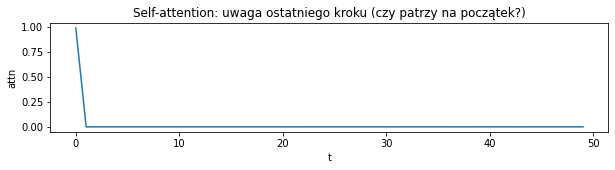

In [101]:
import math

class SelfAttentionClassifier(nn.Module):
    def __init__(self, input_size=2, d_model=32, max_len=256, n_classes=2):
        super().__init__()
        self.d_model = d_model
        self.embed = nn.Linear(input_size, d_model)
        self.pos = nn.Parameter(torch.randn(1, max_len, d_model) * 0.02)

        # jeden head: Q,K,V w jednej macierzy
        self.qkv = nn.Linear(d_model, 3*d_model)
        self.proj = nn.Linear(d_model, d_model)
        self.head = nn.Linear(d_model, n_classes)

    def forward(self, x, return_attn=False):
        B, T, _ = x.shape
        h = self.embed(x) + self.pos[:, :T, :]

        qkv = self.qkv(h)
        q, k, v = qkv.chunk(3, dim=-1)

        scores = (q @ k.transpose(1, 2)) / math.sqrt(self.d_model)  # (B,T,T)
        attn = torch.softmax(scores, dim=-1)
        h2 = attn @ v                                                # (B,T,d)

        h2 = self.proj(h2)
        logits = self.head(h2[:, -1, :])                              # many-to-one: ostatni token

        if return_attn:
            return logits, attn
        return logits

print("Self-attention (mini) — trening")
sa = SelfAttentionClassifier(d_model=32, max_len=512).to(device)
sa = train_simple(sa, seq_len=SEQ_LEN_ATT, steps=300, lr=1e-3)

# Heatmap: gdzie patrzy ostatni krok?
xb_one, yb_one = generate_batch(batch_size=1, seq_len=SEQ_LEN_ATT)
logits, attn = sa(xb_one, return_attn=True)  # (1,T,T)

attn_last = attn[0, -1, :].detach().cpu().numpy()  # (T,)

plt.figure(figsize=(10, 2))
plt.plot(attn_last)
plt.title("Self-attention: uwaga ostatniego kroku (czy patrzy na początek?)")
plt.xlabel("t")
plt.ylabel("attn")
plt.show()


# Mini‑zadania (krótkie)
   1. Zadania dotyczące RNN,LSTM,GRU:
    - Zmień zadanie na „zapamiętaj **ostatni** bit” — powinno się dać nawet dla vanilla RNN.
    - W punkcie 7 (lub przy pomocy scanu) sprwadź relację SEQ_LEN/HIDDEN (można też sterować STEPS) do accuracy, loss i/lub $d_T$, np. ustaw `SEQ_LEN=10`, potem `SEQ_LEN=50` i zobacz, kiedy „ostatni hidden” zaczyna się wykładać, a może inne wartości trzeba ustawić?
    - Punkt 7abc).
   2. Te wszystkie powyższe punkty można przepracować tym  czego już się uczyliśmy, np. zmieniając różne optymalizatory :), np. sprawdzić jakby sobie poradziło zwykłe SGD albo Muon :)
   
   3. Bonusy:
  - Włącz bonus z **attention pooling** i porównaj z baseline: ile kroków treningu potrzeba do sensownej   accuracy?
  - Zrób wykres: accuracy (lub inne) w funkcji `SEQ_LEN` dla:
  - RNN(last hidden),
  - RNN(attention pooling),
  - LSTM(last hidden),
  - LSTM(attention pooling).
  - GRU? 
- Otwórz wykresy bramek i odpowiedz: czy w trudnym zadaniu **forget gate** w LSTM dąży do 1 przez większość czasu?
- (Zaawansowane) Dopisz prosty **bidirectional** RNN/LSTM i porównaj (many‑to‑one często zyskuje).
- (Bardziej zaawansowane) Rozbuduj mini self‑attention do „prawie transformera”: dodaj MLP + residual + LayerNorm.

# BONUS DEMO - modulo-K classification (K=4)

Baseline (ostatni hidden) — RNN — modulo-4
step    1 | loss=1.3937 | test acc=0.247
step  100 | loss=1.3795 | test acc=0.247
step  200 | loss=1.3904 | test acc=0.255
step  300 | loss=1.3929 | test acc=0.248
step  400 | loss=1.3853 | test acc=0.248
step  500 | loss=1.3850 | test acc=0.251
step  600 | loss=1.3836 | test acc=0.251
step  700 | loss=1.3836 | test acc=0.243
step  800 | loss=1.3856 | test acc=0.246
step  900 | loss=1.3835 | test acc=0.249
step 1000 | loss=1.3867 | test acc=0.256

Attention pooling — RNN — modulo-4
step    1 | loss=1.4202 | test acc=0.248
step  100 | loss=1.3834 | test acc=0.246
step  200 | loss=1.3841 | test acc=0.254
step  300 | loss=1.3860 | test acc=0.249
step  400 | loss=1.3858 | test acc=0.243
step  500 | loss=1.3841 | test acc=0.253
step  600 | loss=1.3874 | test acc=0.227
step  700 | loss=1.3891 | test acc=0.249
step  800 | loss=1.3845 | test acc=0.254
step  900 | loss=1.3862 | test acc=0.251
step 1000 | loss=1.3863 | test acc=0.242

Self-attention (mi

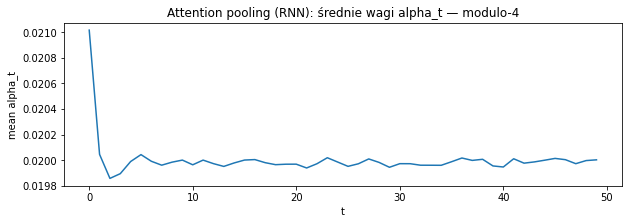

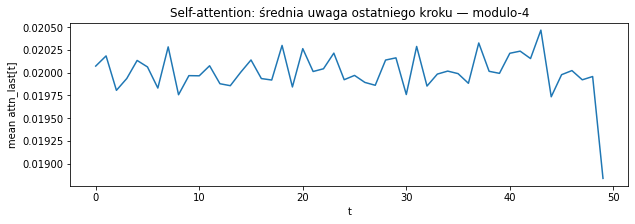

In [120]:
# =========================
# BONUS DEMO: modulo-K classification (K=4)
# =========================

K = 4                      # liczba klas
SEQ_LEN_MOD = 50           # możesz zwiększać (np. 100)
STEPS_MOD = 1000            # możesz zwiększać (np. 800)
HIDDEN_MOD = 32            # hidden_size / d_model
BATCH_MOD = 128

# Generator: wejście jak wcześniej (one-hot 0/1 w wymiarze 2), etykieta: (#ones mod K)
def generate_batch_modK(batch_size, seq_len, K=4, device=None):
    if device is None:
        device = next(iter(models.values())).head.weight.device if "models" in globals() and len(models) else torch.device("cpu")

    # b: (B,T) z {0,1}
    b = torch.randint(0, 2, (batch_size, seq_len), device=device)
    # x: (B,T,2) one-hot
    x = torch.zeros(batch_size, seq_len, 2, device=device)
    x[..., 0] = (b == 0).float()
    x[..., 1] = (b == 1).float()

    y = (b.sum(dim=1) % K).long()  # (B,)
    return x, y


# Ocena accuracy dla K klas
@torch.no_grad()
def eval_acc_modK(model, seq_len, K=4, n_batches=30, batch_size=256):
    model.eval()
    accs = []
    for _ in range(n_batches):
        xb, yb = generate_batch_modK(batch_size, seq_len, K=K, device=device)
        logits = model(xb)
        pred = logits.argmax(dim=1)
        accs.append((pred == yb).float().mean().item())
    return float(np.mean(accs))


# Trening wersji modulo-K (CrossEntropy już obsługuje K klas)
def train_simple_modK(model, seq_len, K=4, steps=500, lr=1e-3, batch_size=128, clip_grad=1.0):
    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=lr)

    for step in range(1, steps+1):
        xb, yb = generate_batch_modK(batch_size, seq_len, K=K, device=device)
        opt.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        if clip_grad is not None:
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad)
        opt.step()

        if step % 100 == 0 or step == 1:
            print(f"step {step:4d} | loss={loss.item():.4f} | test acc={eval_acc_modK(model, seq_len, K=K):.3f}")

    return model


# ---- 1) Baseline RNN (ostatni hidden) — ale z 4 klasami
baseline_rnnK = SeqClassifier(cell_type="rnn", hidden_size=HIDDEN_MOD, n_classes=K).to(device)
print("Baseline (ostatni hidden) — RNN — modulo-4")
baseline_rnnK = train_simple_modK(baseline_rnnK, seq_len=SEQ_LEN_MOD, K=K, steps=STEPS_MOD, lr=1e-3)


# ---- 2) Attention pooling — RNN — z 4 klasami
attn_rnnK = SeqClassifierAttn(cell_type="rnn", hidden_size=HIDDEN_MOD, n_classes=K).to(device)
print("\nAttention pooling — RNN — modulo-4")
attn_rnnK = train_simple_modK(attn_rnnK, seq_len=SEQ_LEN_MOD, K=K, steps=STEPS_MOD, lr=1e-3)


# ---- 3) Self-attention (mini) — z 4 klasami
saK = SelfAttentionClassifier(d_model=HIDDEN_MOD, max_len=512, n_classes=K).to(device)
print("\nSelf-attention (mini) — modulo-4")
saK = train_simple_modK(saK, seq_len=SEQ_LEN_MOD, K=K, steps=STEPS_MOD, lr=1e-3)


print("\nPorównanie test acc (modulo-4):")
print("baseline_rnnK:", eval_acc_modK(baseline_rnnK, SEQ_LEN_MOD, K=K))
print("attn_rnnK:    ", eval_acc_modK(attn_rnnK, SEQ_LEN_MOD, K=K))
print("saK:          ", eval_acc_modK(saK,          SEQ_LEN_MOD, K=K))


# Attention pooling: gdzie patrzy (średnia po batchu)
xb_vis, yb_vis = generate_batch_modK(batch_size=256, seq_len=SEQ_LEN_MOD, K=K, device=device)
logits, alpha = attn_rnnK(xb_vis, return_attn=True)  # alpha: (B,T)
alpha_mean = alpha.mean(dim=0).detach().cpu().numpy()

plt.figure(figsize=(10, 3))
plt.plot(alpha_mean)
plt.title("Attention pooling (RNN): średnie wagi alpha_t — modulo-4")
plt.xlabel("t")
plt.ylabel("mean alpha_t")
plt.show()


# Self-attention: gdzie patrzy ostatni token (średnia po batchu)
xb_vis2, yb_vis2 = generate_batch_modK(batch_size=64, seq_len=SEQ_LEN_MOD, K=K, device=device)
logits, attn = saK(xb_vis2, return_attn=True)   # (B,T,T)
attn_last_mean = attn[:, -1, :].mean(dim=0).detach().cpu().numpy()

plt.figure(figsize=(10, 3))
plt.plot(attn_last_mean)
plt.title("Self-attention: średnia uwaga ostatniego kroku — modulo-4")
plt.xlabel("t")
plt.ylabel("mean attn_last[t]")
plt.show()


## Jak przejść od naszego „mini self-attention” do pełnego Transformera (krótko)

Nasz model z sekcji 10 to **1 head self-attention + projekcja + klasyfikacja**.
Pełny Transformer to po prostu złożenie kilku „klocków” w standardowy blok.

### Krok po kroku: co dokładamy

1) **Multi-head attention**  
Zamiast jednej macierzy uwagi robimy kilka głów (heads), każda liczy własne $Q,K,V$ i własne $A$,
a potem wyniki są łączone (concat + linear).

2) **Residual (skip connection)**  
Nie zastępujemy reprezentacji, tylko dodajemy poprawkę:
$
h \leftarrow h + \mathrm{Attn}(h)
$

3) **LayerNorm**  
Normalizujemy po wymiarze cech (stabilniejszy trening):
$
h \leftarrow \mathrm{LN}(h + \mathrm{Attn}(h))
$

4) **Feed-Forward (MLP) po attention**  
Każdy token przechodzi przez to samo MLP (pozycja po pozycji):
$
h \leftarrow \mathrm{LN}\big(h + \mathrm{FFN}(h)\big)
$

5) **Stackowanie warstw**  
Powtarzamy blok (Attn + FFN) $N$ razy, aby rosnęła „głębia” modelu.

6) (Opcjonalnie) **Maska causal** (dla modeli generujących tekst)  
Uwaga nie może patrzeć w przyszłość (trójkątna maska).

---